# TSP Integrality Gap Analysis

This notebook analyzes the integrality gap results across four TSP formulations:
- **DFJ**: Dantzig-Fulkerson-Johnson (with Held-Karp relaxation)
- **GG**: Gavish-Graves
- **MTZ**: Miller-Tucker-Zemlin
- **Assignment**: Assignment Problem relaxation

## 1. Import Dependencies

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Display settings
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Plot settings
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

## 2. Load and Standardize Data

Load results from all four formulations and standardize column names.

In [ ]:
# Load all results
dfj_df = pd.read_csv("results/dfj_results.csv")
gg_df = pd.read_csv("results/gg_results.csv")
mtz_df = pd.read_csv("results/mtz_results.csv")
assignment_df = pd.read_csv("results/assignment_results.csv")

# Standardize Assignment columns
assignment_df = assignment_df.rename(columns={
    'n_cities': 'n',
    'Z_AP': 'LP_obj',
    'Z_IP': 'IP_obj',
    'Gap_Percent': 'gap_percent',
    'instance': 'instance_idx'
})

# Add formulation labels
dfj_df['formulation'] = 'DFJ'
gg_df['formulation'] = 'GG'
mtz_df['formulation'] = 'MTZ'
assignment_df['formulation'] = 'Assignment'

# Store in dictionary for easy access
formulations = {
    'DFJ': dfj_df,
    'GG': gg_df,
    'MTZ': mtz_df,
    'Assignment': assignment_df
}

# Print summary
for name, df in formulations.items():
    print(f"{name}: {len(df)} instances, columns: {list(df.columns)[:6]}...")

## 3. Summary Statistics

Compare summary statistics across all formulations. We only use n=15 to ensure all methods have complete data without timeouts or missing values.

In [ ]:
# Summary by formulation and structure (n=15)
summary_list = []
for name, df in formulations.items():
    df_n15 = df[df['n'] == 15]
    summary = df_n15.groupby('structure').agg({
        'gap_percent': ['mean', 'std', 'var', 'min', 'max']
    }).round(4)
    summary.columns = ['mean', 'std', 'var', 'min', 'max']
    summary['formulation'] = name
    summary = summary.reset_index()
    summary_list.append(summary)

all_summary = pd.concat(summary_list, ignore_index=True)
all_summary_pivot = all_summary.pivot(index='structure', columns='formulation', values='mean')
all_summary_pivot = all_summary_pivot[['DFJ', 'GG', 'MTZ', 'Assignment']]

print("Mean Integrality Gap (%) by Structure and Formulation (n=15):")
print(all_summary_pivot.round(2))


# Print standard deviation for additional insights
std_pivot = all_summary.pivot(index='structure', columns='formulation', values='std')
std_pivot = std_pivot[['DFJ', 'GG', 'MTZ', 'Assignment']]

print("\nStandard Deviation of Integrality Gap (%) by Structure and Formulation (n=15):")
print(std_pivot.round(4))

In [21]:
# Overall statistics by formulation
overall_stats = []
for name, df in formulations.items():
    overall_stats.append({
        'Formulation': name,
        'Mean Gap (%)': df['gap_percent'].mean(),
        'Std Gap (%)': df['gap_percent'].std(),
        'Min Gap (%)': df['gap_percent'].min(),
        'Max Gap (%)': df['gap_percent'].max()
    })

overall_df = pd.DataFrame(overall_stats)
print("\nOverall Statistics by Formulation:")
print(overall_df.round(2).to_string(index=False))


Overall Statistics by Formulation:
Formulation  Mean Gap (%)  Std Gap (%)  Min Gap (%)  Max Gap (%)
        DFJ          0.06         0.24        -0.00         1.54
         GG         17.31        17.04         0.00        58.02
        MTZ         27.54        29.05         0.01        86.57
 Assignment         24.18        26.64         0.01        87.05


## 4. Visualization: Gap Distribution by Structure

Box plots showing integrality gap distribution for each formulation (n=15 only).

/var/folders/7x/yhw3mdn55nb4mt_qj8_jpp4r0000gn/T/ipykernel_22954/2408782922.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_n15, x='structure', y='gap_percent', order=structure_order, ax=ax, palette=colors)
/var/folders/7x/yhw3mdn55nb4mt_qj8_jpp4r0000gn/T/ipykernel_22954/2408782922.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_n15, x='structure', y='gap_percent', order=structure_order, ax=ax, palette=colors)
/var/folders/7x/yhw3mdn55nb4mt_qj8_jpp4r0000gn/T/ipykernel_22954/2408782922.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sa

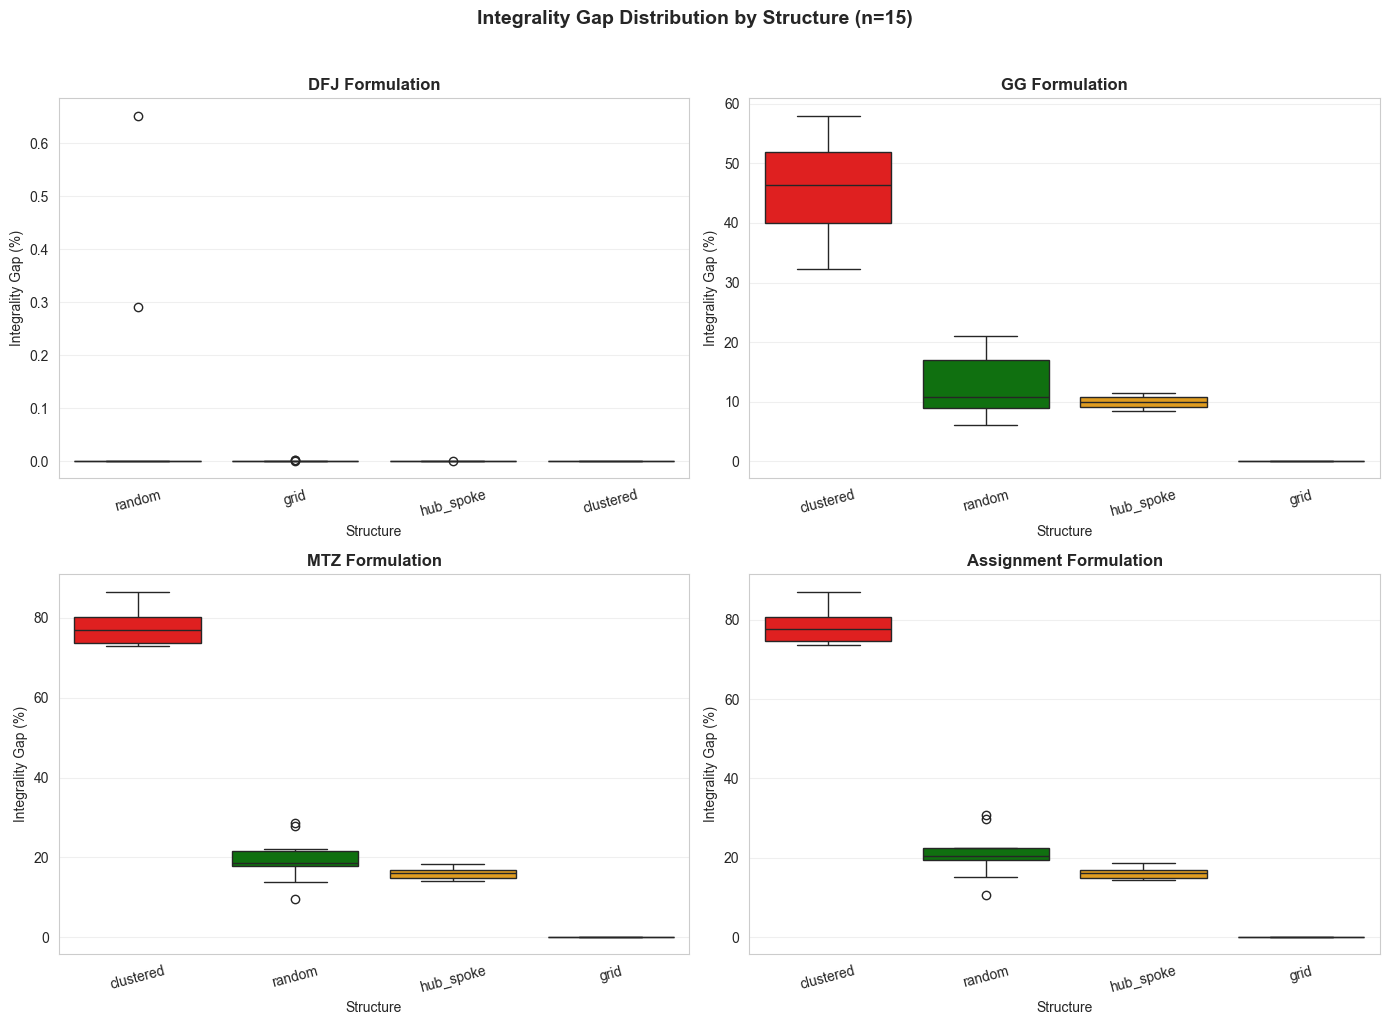

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

formulation_names = ['DFJ', 'GG', 'MTZ', 'Assignment']
colors = {'grid': 'blue', 'random': 'green', 'clustered': 'red', 'hub_spoke': 'orange'}

for idx, name in enumerate(formulation_names):
    ax = axes[idx]
    df = formulations[name]
    data_n15 = df[df['n'] == 15]
    
    # Sort structures by mean gap
    structure_order = data_n15.groupby('structure')['gap_percent'].mean().sort_values(ascending=False).index
    
    sns.boxplot(data=data_n15, x='structure', y='gap_percent', order=structure_order, ax=ax, palette=colors)
    ax.set_xlabel('Structure', fontsize=10)
    ax.set_ylabel('Integrality Gap (%)', fontsize=10)
    ax.set_title(f'{name} Formulation', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Integrality Gap Distribution by Structure (n=15)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 5. Visualization: Gap vs Problem Size

Line plots showing how the gap changes with problem size n.

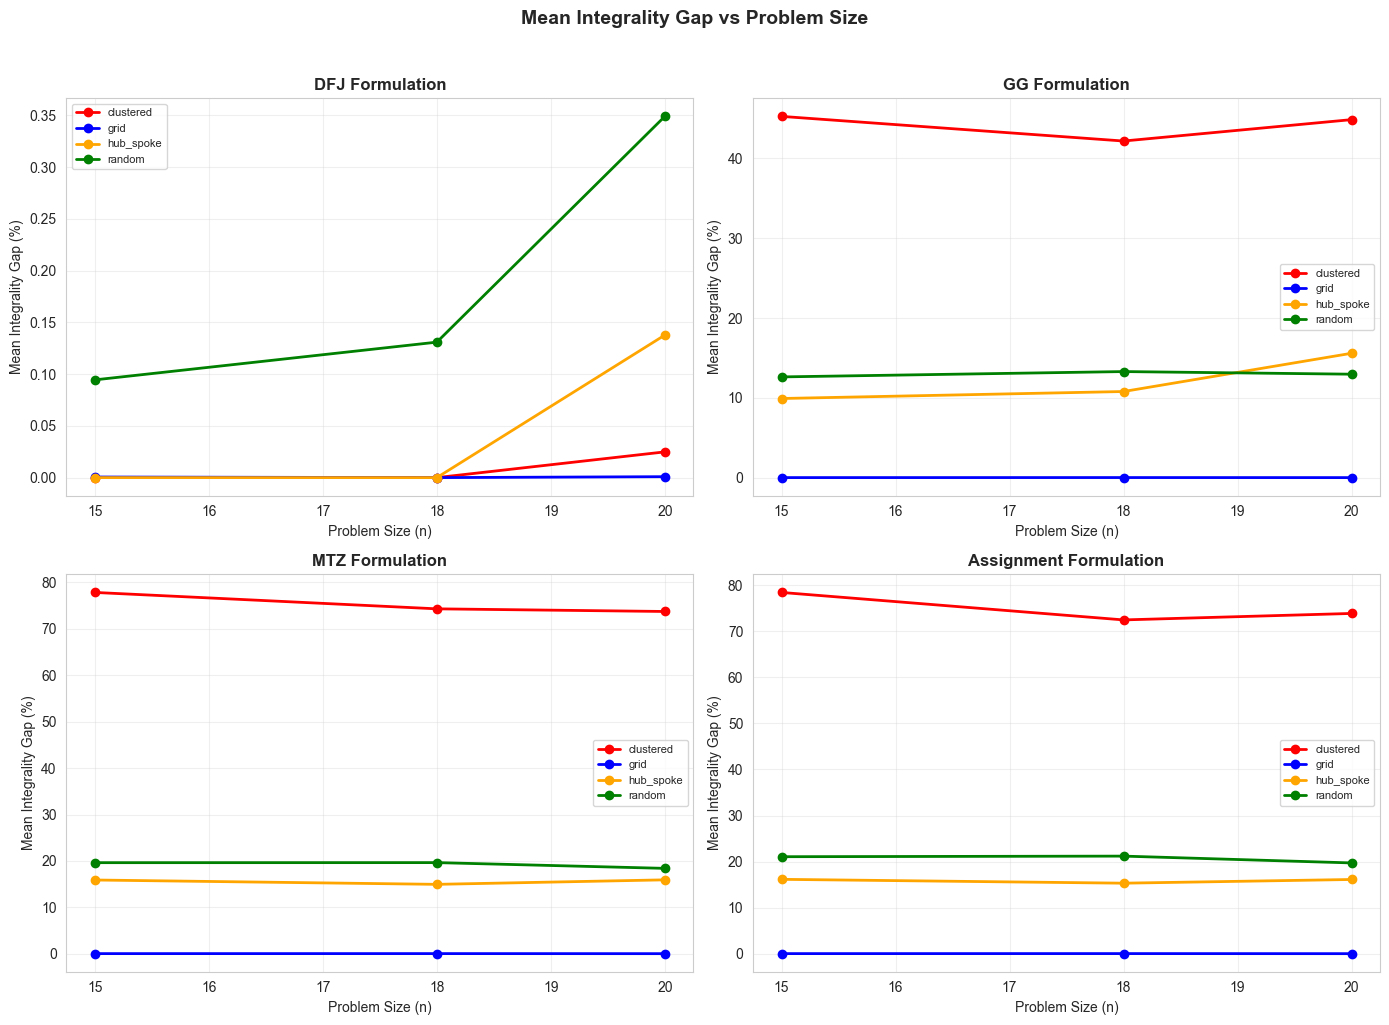

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

structure_colors = {'clustered': 'red', 'grid': 'blue', 'hub_spoke': 'orange', 'random': 'green'}

for idx, name in enumerate(formulation_names):
    ax = axes[idx]
    df = formulations[name]
    
    gap_by_size = df.groupby(['n', 'structure'])['gap_percent'].mean().reset_index()
    
    for structure in sorted(df['structure'].unique()):
        data = gap_by_size[gap_by_size['structure'] == structure]
        ax.plot(data['n'], data['gap_percent'], marker='o', label=structure, 
                linewidth=2, color=structure_colors.get(structure, 'gray'))
    
    ax.set_xlabel('Problem Size (n)', fontsize=10)
    ax.set_ylabel('Mean Integrality Gap (%)', fontsize=10)
    ax.set_title(f'{name} Formulation', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Mean Integrality Gap vs Problem Size', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Visualization: IP vs LP Objectives

Scatter plots showing relationship between LP relaxation and IP optimal values.

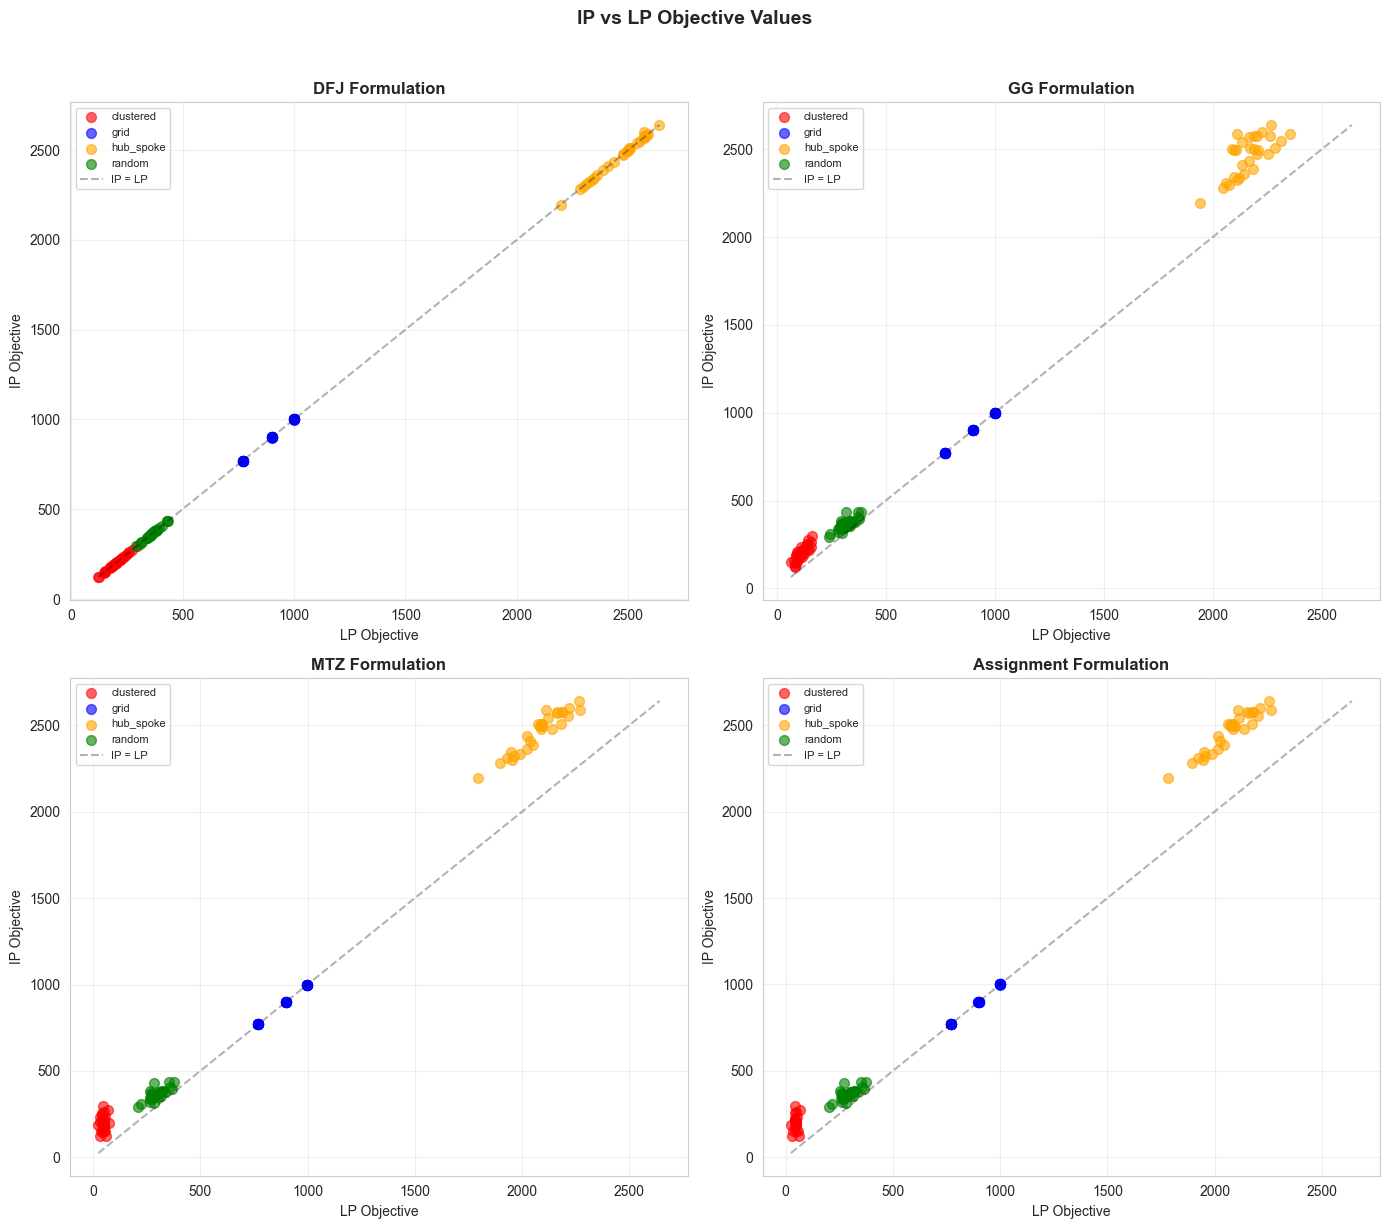

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, name in enumerate(formulation_names):
    ax = axes[idx]
    df = formulations[name]
    
    for structure in sorted(df['structure'].unique()):
        df_struct = df[df['structure'] == structure]
        ax.scatter(df_struct['LP_obj'], df_struct['IP_obj'],
                   label=structure, alpha=0.6, s=50, 
                   color=structure_colors.get(structure, 'gray'))
    
    # Add diagonal line
    min_val = min(df['LP_obj'].min(), df['IP_obj'].min())
    max_val = max(df['LP_obj'].max(), df['IP_obj'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='IP = LP')
    
    ax.set_xlabel('LP Objective', fontsize=10)
    ax.set_ylabel('IP Objective', fontsize=10)
    ax.set_title(f'{name} Formulation', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('IP vs LP Objective Values', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Cross-Formulation Comparison

Compare mean gaps across all formulations side-by-side.

<Figure size 1200x600 with 0 Axes>

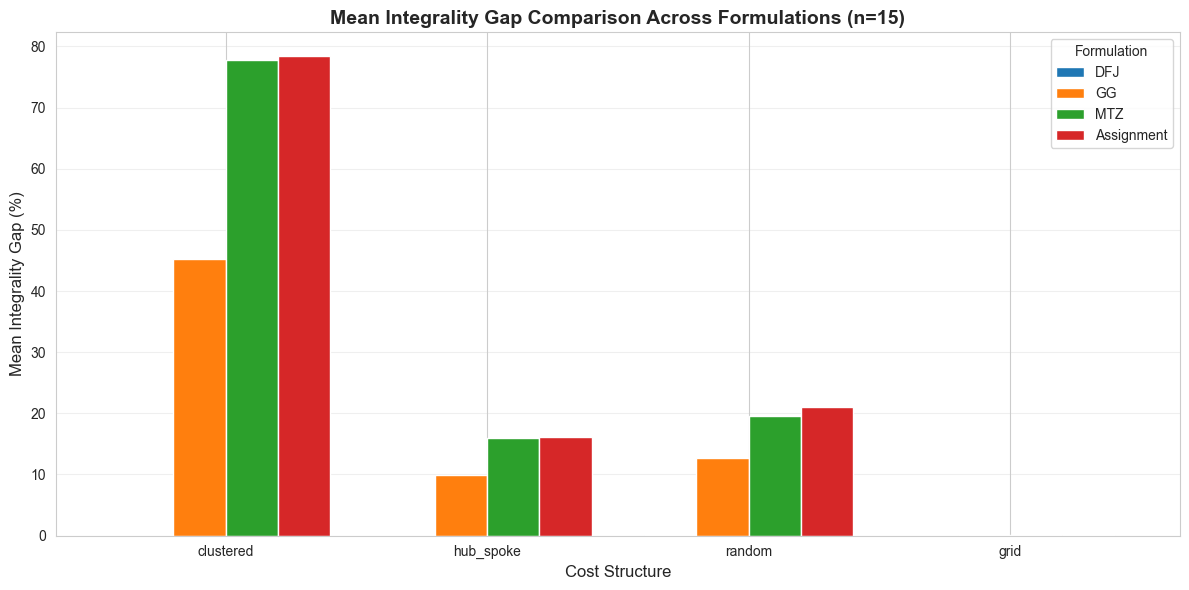

In [25]:
# Prepare data for comparison
comparison_data = []
for name, df in formulations.items():
    data_n15 = df[df['n'] == 15]
    for structure in data_n15['structure'].unique():
        mean_gap = data_n15[data_n15['structure'] == structure]['gap_percent'].mean()
        comparison_data.append({
            'Formulation': name,
            'Structure': structure,
            'Mean Gap (%)': mean_gap
        })

comparison_df = pd.DataFrame(comparison_data)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
structure_order = ['clustered', 'hub_spoke', 'random', 'grid']
formulation_order = ['DFJ', 'GG', 'MTZ', 'Assignment']

pivot_df = comparison_df.pivot(index='Structure', columns='Formulation', values='Mean Gap (%)')
pivot_df = pivot_df.reindex(structure_order)[formulation_order]

pivot_df.plot(kind='bar', width=0.8, figsize=(12, 6))
plt.xlabel('Cost Structure', fontsize=12)
plt.ylabel('Mean Integrality Gap (%)', fontsize=12)
plt.title('Mean Integrality Gap Comparison Across Formulations (n=15)', fontsize=14, fontweight='bold')
plt.legend(title='Formulation')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Statistical Analysis

ANOVA tests to determine if gaps differ significantly across structures for each formulation.

In [27]:
print("ANOVA Test Results (Gap ~ Structure) (n=15):")
print("=" * 60)

anova_results = []
for name, df in formulations.items():
    df_n15 = df[df['n'] == 15]
    groups = [df_n15[df_n15['structure'] == s]['gap_percent'].values 
              for s in df_n15['structure'].unique()]
    
    f_stat, p_value = stats.f_oneway(*groups)
    
    significance = 'Yes' if p_value < 0.05 else 'No'
    anova_results.append({
        'Formulation': name,
        'F-statistic': f_stat,
        'P-value': p_value,
        'Significant (p<0.05)': significance
    })
    
    print(f"\n{name}:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.2e}")
    print(f"  Conclusion: Gaps {'differ significantly' if p_value < 0.05 else 'do not differ significantly'} across structures")

print("\n" + "=" * 60)
anova_df = pd.DataFrame(anova_results)
print("\nSummary Table:")
print(anova_df.to_string(index=False))

ANOVA Test Results (Gap ~ Structure) (n=15):

DFJ:
  F-statistic: 1.8956
  P-value: 1.48e-01
  Conclusion: Gaps do not differ significantly across structures

GG:
  F-statistic: 151.7785
  P-value: 1.75e-20
  Conclusion: Gaps differ significantly across structures

MTZ:
  F-statistic: 820.5236
  P-value: 3.50e-33
  Conclusion: Gaps differ significantly across structures

Assignment:
  F-statistic: 803.9408
  P-value: 5.03e-33
  Conclusion: Gaps differ significantly across structures


Summary Table:
Formulation  F-statistic      P-value Significant (p<0.05)
        DFJ     1.895595 1.477922e-01                   No
         GG   151.778479 1.745790e-20                  Yes
        MTZ   820.523620 3.500367e-33                  Yes
 Assignment   803.940821 5.027299e-33                  Yes


In [28]:
# One-way ANOVA: Gap ~ Formulation (n=15)
print("ANOVA Test: Gap ~ Formulation (n=15)")
print("=" * 60)

# Combine all data for n=15
combined_df = pd.concat([
    df[df['n'] == 15][['structure', 'gap_percent', 'formulation']] 
    for df in formulations.values()
], ignore_index=True)

formulation_groups = [combined_df[combined_df['formulation'] == f]['gap_percent'].values 
                      for f in ['DFJ', 'GG', 'MTZ', 'Assignment']]
f_stat, p_value = stats.f_oneway(*formulation_groups)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Conclusion: Gaps {'differ significantly' if p_value < 0.05 else 'do not differ significantly'} across formulations")

ANOVA Test: Gap ~ Formulation (n=15)
F-statistic: 13.7097
P-value: 5.54e-08
Conclusion: Gaps differ significantly across formulations


In [29]:
# Two-way ANOVA: Gap ~ Structure * Formulation (n=15)
print("TWO-WAY ANOVA: Gap ~ Structure * Formulation (n=15)")
print("=" * 60)

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('gap_percent ~ C(structure) * C(formulation)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table.round(4))

print("\nInterpretation:")
print("- C(structure): Effect of cost structure on integrality gap")
print("- C(formulation): Effect of LP formulation on integrality gap")
print("- C(structure):C(formulation): Interaction effect")

TWO-WAY ANOVA: Gap ~ Structure * Formulation (n=15)
                                 sum_sq     df          F  PR(>F)
C(structure)                 57896.1427    3.0  1427.4875     0.0
C(formulation)               21978.8851    3.0   541.9115     0.0
C(structure):C(formulation)  23521.7112    9.0   193.3171     0.0
Residual                      1946.7875  144.0        NaN     NaN

Interpretation:
- C(structure): Effect of cost structure on integrality gap
- C(formulation): Effect of LP formulation on integrality gap
- C(structure):C(formulation): Interaction effect


## 9. Key Findings

Summary of main observations (n=15 instances).

In [31]:
print("KEY FINDINGS (n=15 instances)")
print("=" * 70)

for name, df in formulations.items():
    data_n15 = df[df['n'] == 15]
    structure_gaps = data_n15.groupby('structure')['gap_percent'].mean().sort_values(ascending=False)
    
    print(f"\n{name} Formulation:")
    print(f"  Overall mean gap: {data_n15['gap_percent'].mean():.2f}%")
    print(f"  Gap range: {data_n15['gap_percent'].min():.2f}% - {data_n15['gap_percent'].max():.2f}%")
    print(f"  Largest gap structure: {structure_gaps.index[0]} ({structure_gaps.iloc[0]:.2f}%)")
    print(f"  Smallest gap structure: {structure_gaps.index[-1]} ({structure_gaps.iloc[-1]:.2f}%)")

print("\n" + "=" * 70)
print("\nFormulation Ranking (by mean gap, lowest is best):")
ranking = [(name, formulations[name][formulations[name]['n'] == 15]['gap_percent'].mean()) 
           for name in formulation_names]
ranking.sort(key=lambda x: x[1])
for i, (name, gap) in enumerate(ranking, 1):
    print(f"  {i}. {name}: {gap:.2f}%")

KEY FINDINGS (n=15 instances)

DFJ Formulation:
  Overall mean gap: 0.02%
  Gap range: -0.00% - 0.65%
  Largest gap structure: random (0.09%)
  Smallest gap structure: clustered (-0.00%)

GG Formulation:
  Overall mean gap: 16.97%
  Gap range: 0.00% - 58.02%
  Largest gap structure: clustered (45.27%)
  Smallest gap structure: grid (0.03%)

MTZ Formulation:
  Overall mean gap: 28.36%
  Gap range: 0.01% - 86.57%
  Largest gap structure: clustered (77.83%)
  Smallest gap structure: grid (0.05%)

Assignment Formulation:
  Overall mean gap: 28.92%
  Gap range: 0.01% - 87.05%
  Largest gap structure: clustered (78.39%)
  Smallest gap structure: grid (0.05%)


Formulation Ranking (by mean gap, lowest is best):
  1. DFJ: 0.02%
  2. GG: 16.97%
  3. MTZ: 28.36%
  4. Assignment: 28.92%
